In [1]:
import os
import numpy as np
import pandas as pd
import cv2

from glob import glob

from skimage.io import imread

from keras.preprocessing.image import ImageDataGenerator
from sklearn.utils import shuffle


import matplotlib.image as mpimg
import matplotlib.pyplot as plt

%matplotlib inline

/home/faisal/anaconda3/envs/ai/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
train_df = pd.read_csv('./data/train.csv')
test_df = pd.read_csv('./data/test.csv')

train_df.head()


Image_name  attrib_01  attrib_02  attrib_03  attrib_04  attrib_05  \
0  Image-1.jpg          0          0          0          0          0   
1  Image-2.jpg          1          0          0          1          0   
2  Image-3.jpg          1          0          0          1          0   
3  Image-4.jpg          1          0          0          1          0   
4  Image-5.jpg          0          0          0          1          0   

   attrib_06  attrib_07  attrib_08  attrib_09    ...      attrib_76  \
0          1          1          0          0    ...              1   
1          0          1          1          0    ...              1   
2          0          0          1          1    ...              1   
3          0          0          0          1    ...              1   
4          0          0          0          1    ...              0   

   attrib_77  attrib_78  attrib_79  attrib_80  attrib_81  attrib_82  \
0          0          0          0          0          0          0   
1          1          1          1          0          0          0   
2          0          0          1          0          1          0   
3          0          1          1          1          0          0   
4          0          0          1          0          0          0   

   attrib_83  attrib_84  attrib_85  
0          0          0          1  
1          1          0          1  
2          1          0          1  
3          0          0          0  
4          1          0          0  

[5 rows x 86 columns]

In [3]:
train_df['Image_name'] = train_df['Image_name'].map(lambda x: './data/train_img/' + x)

In [4]:
train_df = shuffle(train_df)
train_df.head()

Image_name  attrib_01  attrib_02  attrib_03  \
11778  ./data/train_img/Image-11779.jpg          0          1          0   
271      ./data/train_img/Image-272.jpg          0          0          0   
3366    ./data/train_img/Image-3367.jpg          1          0          0   
12332  ./data/train_img/Image-12333.jpg          0          1          0   
10567  ./data/train_img/Image-10568.jpg          0          0          0   

       attrib_04  attrib_05  attrib_06  attrib_07  attrib_08  attrib_09  \
11778          0          0          1          1          0          0   
271            0          0          0          1          0          0   
3366           1          0          0          0          0          1   
12332          1          1          1          1          0          0   
10567          0          0          0          1          0          0   

         ...      attrib_76  attrib_77  attrib_78  attrib_79  attrib_80  \
11778    ...              0          1          0          0          0   
271      ...              0          0          0          1          0   
3366     ...              1          0          1          1          1   
12332    ...              0          1          0          0          0   
10567    ...              0          0          0          1          0   

       attrib_81  attrib_82  attrib_83  attrib_84  attrib_85  
11778          0          0          1          1          0  
271            0          0          0          0          1  
3366           0          0          0          0          0  
12332          0          1          0          1          1  
10567          0          0          1          0          1  

[5 rows x 86 columns]

In [6]:
train_datagen = ImageDataGenerator(width_shift_range=0.2, 
                                   height_shift_range=0.2,
                                   rescale=1. / 255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True, 
                                   rotation_range = 20,
                                   channel_shift_range=0.2,
#                                    zca_whitening=True
                                )

def flow_from_dataframe(img_data_gen, in_df, path_col, y_col, seed = None, **dflow_args):
    base_dir = os.path.dirname(in_df[path_col].values[0])    
    print('## Ignore next message from keras, values are replaced anyways')
    df_gen = img_data_gen.flow_from_directory(base_dir, class_mode = 'sparse',seed = seed,**dflow_args)
    df_gen.filenames = in_df[path_col].values
    df_gen.classes = in_df.loc[:, in_df.columns != path_col].values
    df_gen.samples = in_df.shape[0]
    df_gen.n = in_df.shape[0]
    df_gen._set_index_array()
    df_gen.directory = '' # since we have the full path
    print('Reinserting dataframe: {} images'.format(in_df.shape[0]))
    
    return df_gen

def gen_func(in_df, rgb_gen, image_size = (224, 224), batch_size = 8, seed = None):
    if seed is None:
        seed = np.random.choice(range(1000))
        
    rgb_gen = flow_from_dataframe(rgb_gen, 
                                      in_df, 
                                      path_col = 'Image_name',
                                      y_col = 'id', 
                                      color_mode = 'rgb',
                                      target_size = image_size,
                                      batch_size = batch_size,
                                      seed = seed)
    for x, i in rgb_gen:
        idx = (rgb_gen.batch_index - 1) * rgb_gen.batch_size
#         print(rgb_gen.classes[idx: idx+rgb_gen.batch_size].shape)
#         print(rgb_gen.filenames[idx : idx + rgb_gen.batch_size])
        yield x, rgb_gen.classes[idx: idx+rgb_gen.batch_size]

# initial_gen = gen_func(train_df, ImageDataGenerator(), batch_size=150)
train_gen = gen_func(train_df, train_datagen, batch_size=10*10)

/home/faisal/anaconda3/envs/ai/lib/python3.6/site-packages/keras/preprocessing/image.py:492: UserWarning: This ImageDataGenerator specifies `zca_whitening`, which overrides setting of `featurewise_center`.
  warnings.warn('This ImageDataGenerator specifies '


In [97]:
train_datagen.fit(list(train_gen))

/home/faisal/anaconda3/envs/ai/lib/python3.6/site-packages/keras/preprocessing/image.py:571: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/faisal/anaconda3/envs/ai/lib/python3.6/site-packages/keras/preprocessing/image.py:589: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


KeyboardInterrupt: 

In [96]:
X, Y = next(train_gen)
Y.shape

## Ignore next message from keras, values are replaced anyways
Found 0 images belonging to 0 classes.
Reinserting dataframe: 12600 images


/home/faisal/anaconda3/envs/ai/lib/python3.6/site-packages/keras/preprocessing/image.py:571: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/faisal/anaconda3/envs/ai/lib/python3.6/site-packages/keras/preprocessing/image.py:589: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


(100, 85)

/home/faisal/anaconda3/envs/ai/lib/python3.6/site-packages/keras/preprocessing/image.py:571: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/faisal/anaconda3/envs/ai/lib/python3.6/site-packages/keras/preprocessing/image.py:589: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


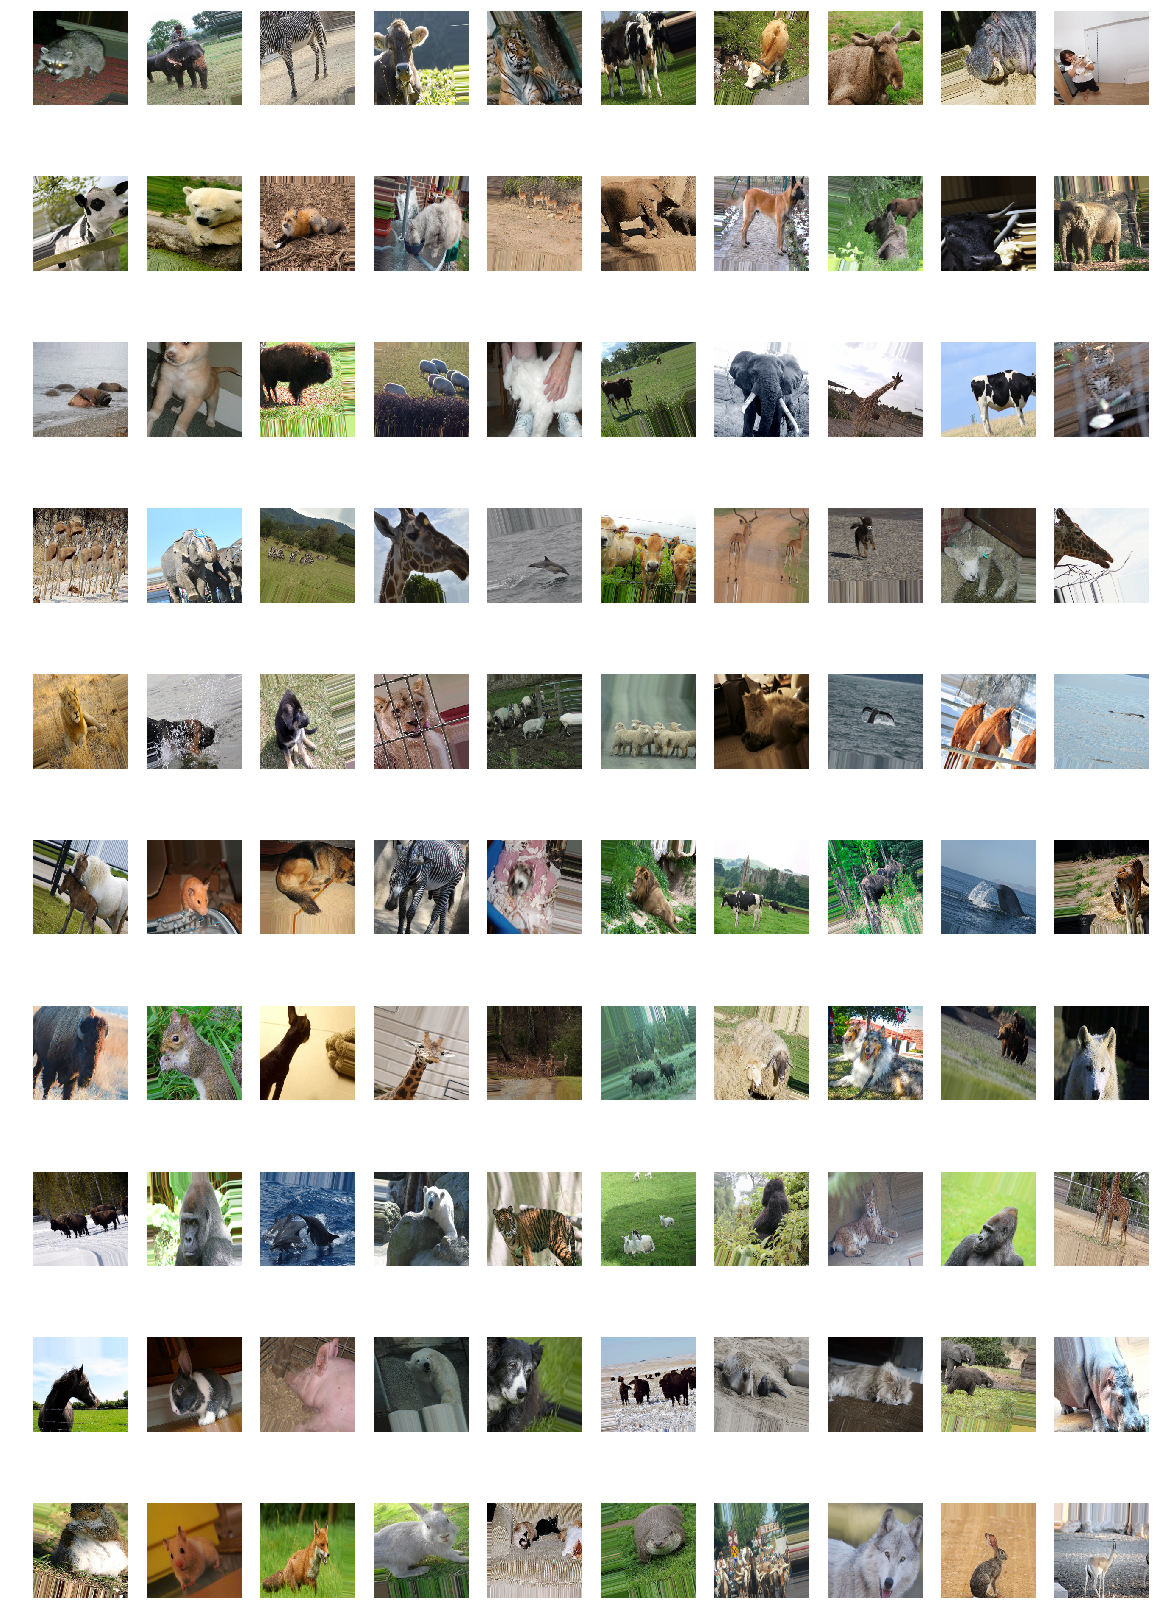

In [9]:
X, Y = next(train_gen)
rows = 10
cols = 10

fig, m_axs = plt.subplots(rows, cols, figsize = (20, 30))
[c_ax.axis('off') for c_ax in m_axs.flatten()]
m_axs = [c_ax for c_ax in m_axs.flatten()]

for ax, img in zip(m_axs, X):
#     img = imread('./data/train_img/' + c_row['Image_name'])
    
#     img = cv2.resize(img, (512, 512))
    ax.imshow(img)
plt.savefig('augmented_data.jpg')

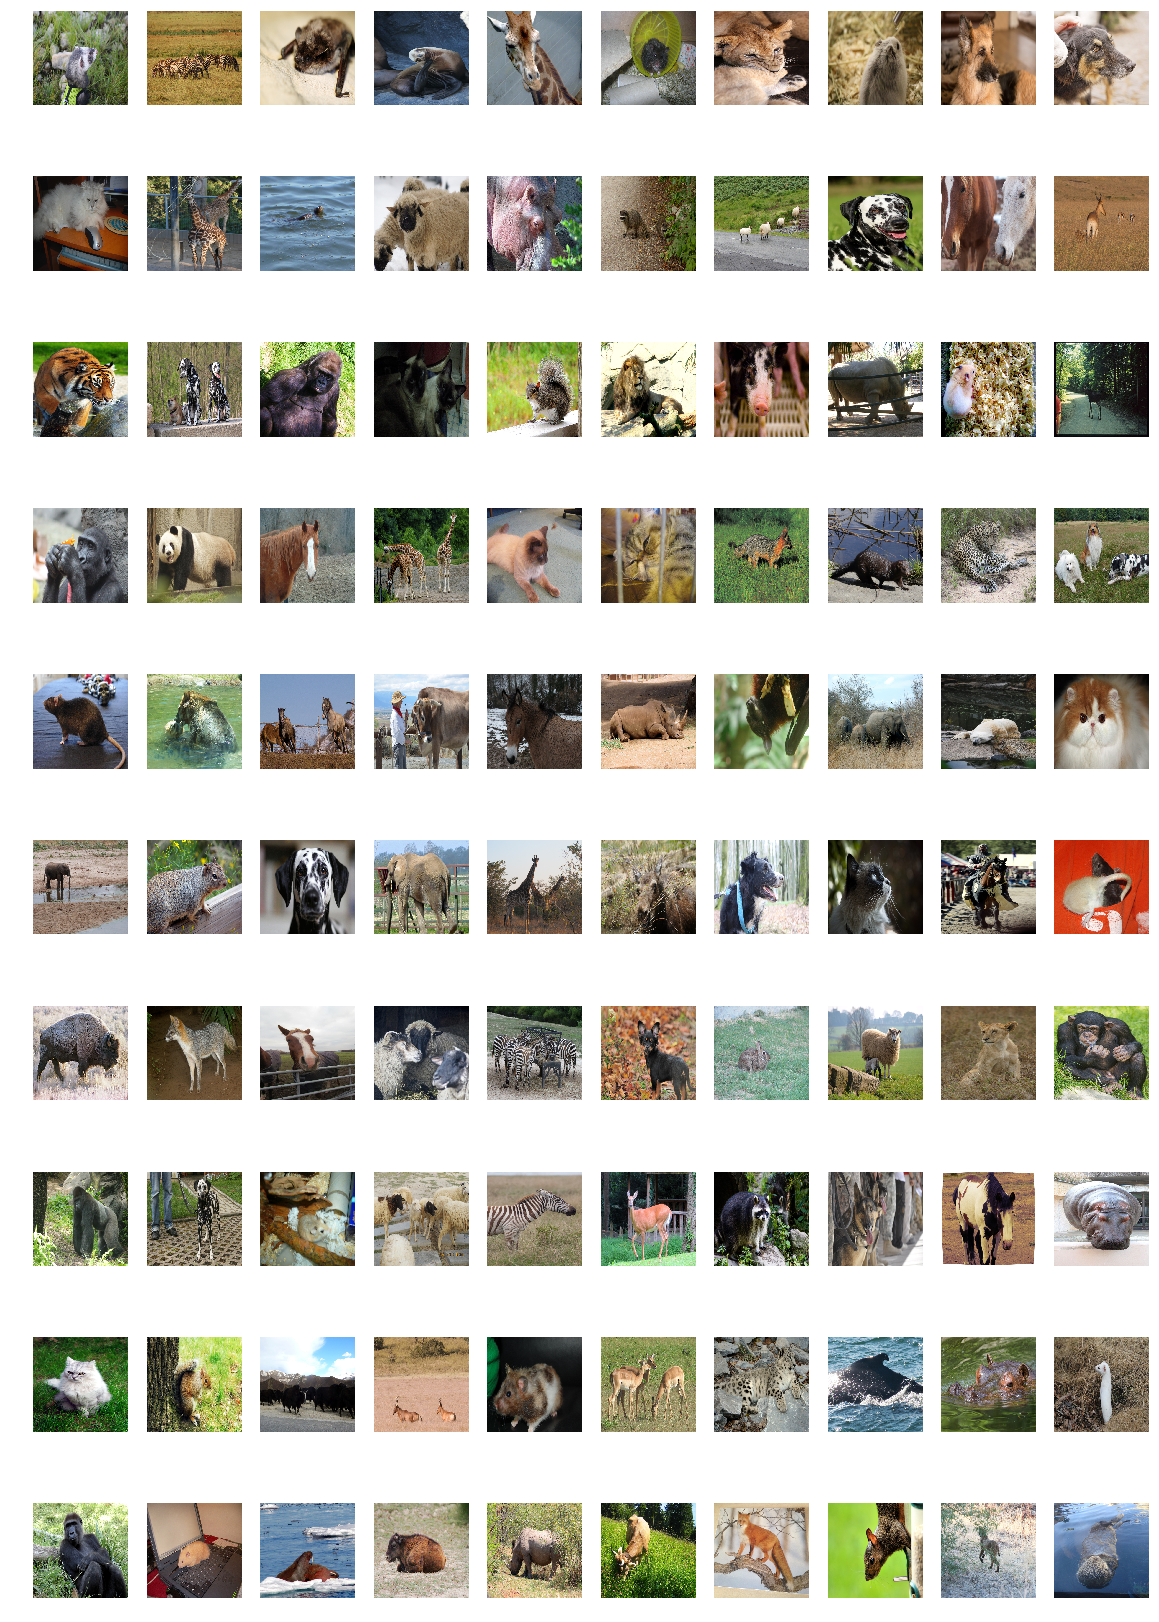

In [46]:
rows = 10
cols = 10

fig, m_axs = plt.subplots(rows, cols, figsize = (20, 30))
[c_ax.axis('off') for c_ax in m_axs.flatten()]
m_axs = [c_ax for c_ax in m_axs.flatten()]

for ax, (_, c_row) in zip(m_axs, train_df.sample(rows*cols).iterrows()):
    img = imread('./data/train_img/' + c_row['Image_name'])
    img = cv2.resize(img, (512, 512))
    ax.imshow(img)

In [48]:
train_df.sample(1)

Image_name  attrib_01  attrib_02  attrib_03  attrib_04  attrib_05  \
6884  Image-6885.jpg          0          0          0          1          0   

      attrib_06  attrib_07  attrib_08  attrib_09    ...      attrib_76  \
6884          0          1          0          0    ...              0   

      attrib_77  attrib_78  attrib_79  attrib_80  attrib_81  attrib_82  \
6884          0          0          1          0          0          0   

      attrib_83  attrib_84  attrib_85  
6884          1          0          1  

[1 rows x 86 columns]

In [68]:
with open('./data/attributes.txt', 'r') as f:
#     mapping = {"attrib_%02d"%(int(l.split()[0])):l.split()[1] for l in f.readlines()}
    mapping = [l.split()[1] for l in f.readlines()]

print(mapping)

['black', 'white', 'blue', 'brown', 'gray', 'orange', 'red', 'yellow', 'patches', 'spots', 'stripes', 'furry', 'hairless', 'toughskin', 'big', 'small', 'bulbous', 'lean', 'flippers', 'hands', 'hooves', 'pads', 'paws', 'longleg', 'longneck', 'tail', 'chewteeth', 'meatteeth', 'buckteeth', 'strainteeth', 'horns', 'claws', 'tusks', 'smelly', 'flys', 'hops', 'swims', 'tunnels', 'walks', 'fast', 'slow', 'strong', 'weak', 'muscle', 'bipedal', 'quadrapedal', 'active', 'inactive', 'nocturnal', 'hibernate', 'agility', 'fish', 'meat', 'plankton', 'vegetation', 'insects', 'forager', 'grazer', 'hunter', 'scavenger', 'skimmer', 'stalker', 'newworld', 'oldworld', 'arctic', 'coastal', 'desert', 'bush', 'plains', 'forest', 'fields', 'jungle', 'mountains', 'ocean', 'ground', 'water', 'tree', 'cave', 'fierce', 'timid', 'smart', 'group', 'solitary', 'nestspot', 'domestic']


['Image-4949.jpg' 1 0 0 1 0 0 0 0 0 1 0 0 1 1 0 1 0 0 0 0 1 0 0 0 1 0 0 1
 1 0 1 0 0 0 0 0 1 0 0 1 1 0 1 0 0 0 0 0 0 1 1 1 0 1 0 0 0 0 1 1 0 0 1 1 0
 0 1 1 1 0 0 0 0 1 1 0 0 0 1 0 0 0 0 0 0]
['black', 'brown', 'spots', 'hairless', 'toughskin', 'small', 'hooves', 'longneck', 'meatteeth', 'buckteeth', 'horns', 'swims', 'fast', 'slow', 'weak', 'hibernate', 'agility', 'fish', 'plankton', 'hunter', 'scavenger', 'newworld', 'oldworld', 'desert', 'bush', 'plains', 'ocean', 'ground', 'fierce']


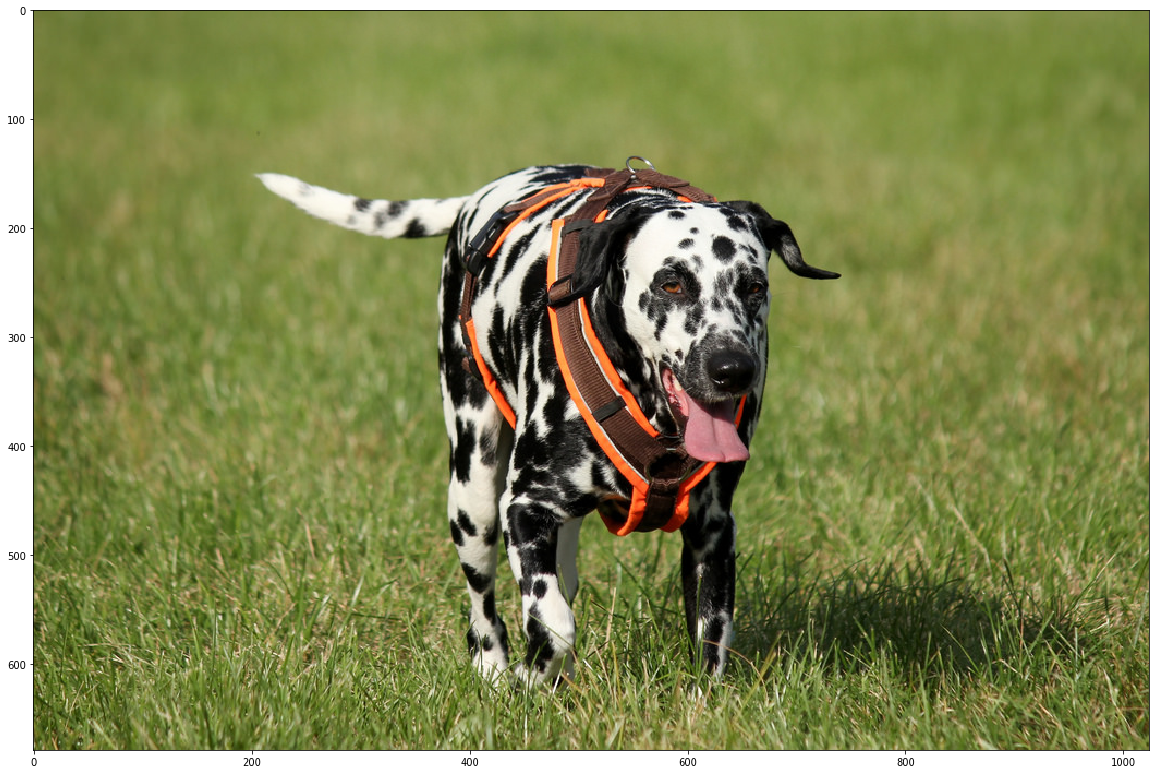

In [104]:
plt.figure(figsize=(20, 20))
for _, c_row in train_df.sample(1).iterrows():
    img = imread('./data/train_img/' + c_row['Image_name'])
    plt.imshow(img)
    print (c_row.values)
    print([mapping[i] for i in (c_row.values[1:].nonzero()[0])])